In [1]:
import pandas as pd
import dask.dataframe as dd
import sqlite3
import numpy as np
from matplotlib import pyplot as plt
from scripts.pq_operations import *

In [41]:
dtypes = {
    'id': 'string',
    'wt_prediction': 'float32',    # changed from float16
    'mut_prediction': 'float32',   # changed from float16
    'pred_difference': 'float32',  # changed from float16
    'vcf_id': 'category',
    'mirna_accession': 'category',
    'gene_id': 'category',
    'is_intron': 'bool',
    'mutation_context': 'category', 
    'mutsig_key': 'category',
    'is_gene_upregulated': 'bool',
    'mutsig': 'category',
    'gene_name': 'category',
    'biotype': 'category',
    'cancer_type': 'category'
}

comb = "results/combined.csv"
real = dd.read_csv(comb, dtype=dtypes)
real = real.drop(columns=["experiment", "mutsig_key"])

df = pd.read_csv("results/the_final_data.csv")

filter_logic = (abs(df['log2_odds_ratio']) > 0.32) & (df['p_adj'] < 0.05)
df["is_significant"] = filter_logic
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

# add genes table
sqlite_conn = sqlite3.connect('data/mirscribe_backup.db')
genes = pd.read_sql('SELECT * FROM genes', sqlite_conn)
mirnas = pd.read_sql('SELECT * FROM mirnas', sqlite_conn)
sqlite_conn.close()


# add genes table details
cols_to_merge = ['gene_id', 'is_oncogene_oncokb', 'is_tsupp_oncokb',
       'is_driver_intogen', 'tier_cosmic', 'is_hallmark_cosmic',
       'is_tsupp_cosmic', 'is_oncogene_cosmic', 'is_oncogene_consensus',
       'is_tsupp_consensus', 'is_gene_of_interest', 'cancer_gene_role']

df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )

In [9]:
real.head()

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,mutation_context,is_gene_upregulated,mutsig,gene_name,biotype,cancer_type
0,PD10010a_10_100900726_G_A_MIMAT0000257,0.684779,0.269260,-0.416,PD10010a,MIMAT0000257,ENSG00000172987,True,C[C>T]G,True,SBS1,HPSE2,protein_coding,nnn
1,PD10010a_10_100900726_G_A_MIMAT0000441,0.628840,0.424571,-0.204,PD10010a,MIMAT0000441,ENSG00000172987,True,C[C>T]G,True,SBS1,HPSE2,protein_coding,nnn
2,PD10010a_10_100900726_G_A_MIMAT0001635,0.682595,0.397291,-0.285,PD10010a,MIMAT0001635,ENSG00000172987,True,C[C>T]G,True,SBS1,HPSE2,protein_coding,nnn
3,PD10010a_10_100900726_G_A_MIMAT0003264,0.831073,0.324415,-0.507,PD10010a,MIMAT0003264,ENSG00000172987,True,C[C>T]G,True,SBS1,HPSE2,protein_coding,nnn
4,PD10010a_10_100900726_G_A_MIMAT0003284,0.330688,0.552029,0.221,PD10010a,MIMAT0003284,ENSG00000172987,True,C[C>T]G,False,SBS1,HPSE2,protein_coding,nnn


In [ ]:
# Create a single DataFrame that filters significant genes and their classifications
significant_genes = df[df.is_significant]

# Create sets of gene IDs for each category of interest
up_onc = set(significant_genes[significant_genes.is_oncogene_consensus & significant_genes.is_gene_upregulated]['gene_id'])
up_tsupp = set(significant_genes[significant_genes.is_tsupp_consensus & significant_genes.is_gene_upregulated]['gene_id'])
down_onc = set(significant_genes[significant_genes.is_oncogene_consensus & ~significant_genes.is_gene_upregulated]['gene_id'])
down_tsupp = set(significant_genes[significant_genes.is_tsupp_consensus & ~significant_genes.is_gene_upregulated]['gene_id'])

# Get distributions using these sets
up_onc_dist = real[real.gene_id.isin(up_onc)].mutsig.value_counts().compute()
up_tsupp_dist = real[real.gene_id.isin(up_tsupp)].mutsig.value_counts().compute()
down_onc_dist = real[real.gene_id.isin(down_onc)].mutsig.value_counts().compute()
down_tsupp_dist = real[real.gene_id.isin(down_tsupp)].mutsig.value_counts().compute()


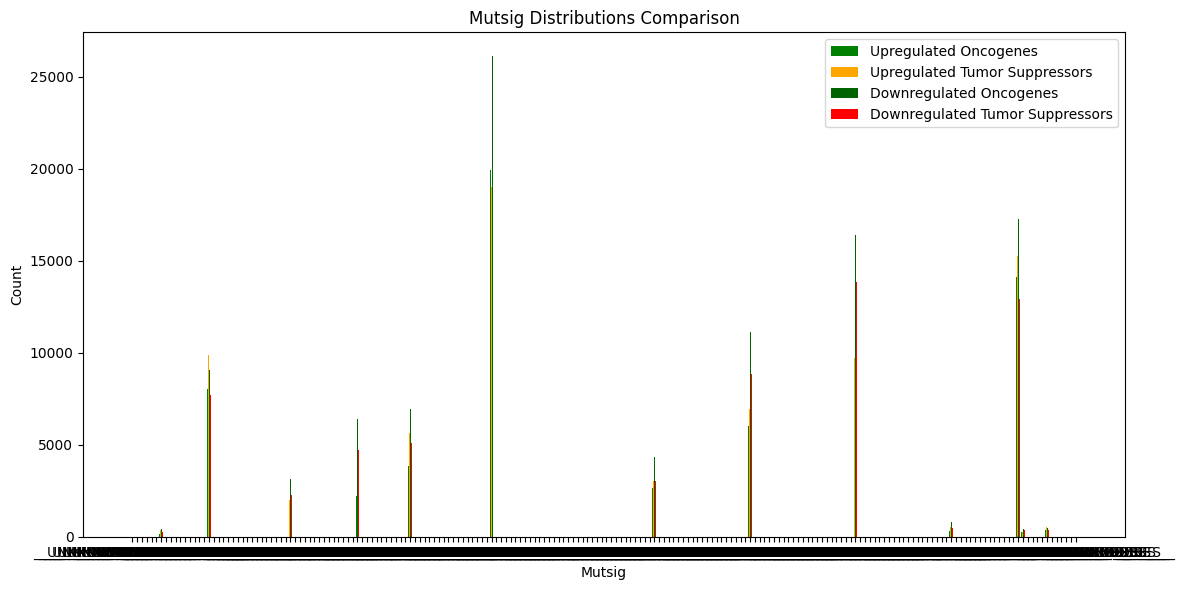

In [4]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Set width of bars and positions
bar_width = 0.2
r1 = np.arange(len(up_onc_dist))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create bars
plt.bar(r1, up_onc_dist.values, width=bar_width, label='Upregulated Oncogenes', color='green')
plt.bar(r2, up_tsupp_dist.values, width=bar_width, label='Upregulated Tumor Suppressors', color='orange')
plt.bar(r3, down_onc_dist.values, width=bar_width, label='Downregulated Oncogenes', color='darkgreen')
plt.bar(r4, down_tsupp_dist.values, width=bar_width, label='Downregulated Tumor Suppressors', color='red')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.xticks([r + bar_width*1.5 for r in range(len(up_onc_dist))], up_onc_dist.index)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [25]:
test = dd.read_csv("results/combined.csv")
test.head()

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,mutation_context,mutsig_key,is_gene_upregulated,experiment,mutsig,gene_name,biotype,cancer_type
0,PD10010a_10_100900726_G_A_MIMAT0000257,0.684779,0.269260,-0.416,PD10010a,MIMAT0000257,ENSG00000172987,True,C[C>T]G,PD10010a_C[C>T]G,True,0,SBS1,HPSE2,protein_coding,nnn
1,PD10010a_10_100900726_G_A_MIMAT0000441,0.628840,0.424571,-0.204,PD10010a,MIMAT0000441,ENSG00000172987,True,C[C>T]G,PD10010a_C[C>T]G,True,0,SBS1,HPSE2,protein_coding,nnn
2,PD10010a_10_100900726_G_A_MIMAT0001635,0.682595,0.397291,-0.285,PD10010a,MIMAT0001635,ENSG00000172987,True,C[C>T]G,PD10010a_C[C>T]G,True,0,SBS1,HPSE2,protein_coding,nnn
3,PD10010a_10_100900726_G_A_MIMAT0003264,0.831072,0.324415,-0.507,PD10010a,MIMAT0003264,ENSG00000172987,True,C[C>T]G,PD10010a_C[C>T]G,True,0,SBS1,HPSE2,protein_coding,nnn
4,PD10010a_10_100900726_G_A_MIMAT0003284,0.330688,0.552029,0.221,PD10010a,MIMAT0003284,ENSG00000172987,True,C[C>T]G,PD10010a_C[C>T]G,False,0,SBS1,HPSE2,protein_coding,nnn


In [26]:
type(test)

dask_expr._collection.DataFrame

In [ ]:
real = real.categorize(columns = ["mutsig"])
real.pivot_table(index='gene_id', columns='mutsig', values='id', aggfunc='count')

,SBS0,SBS1,SBS13,SBS17,SBS18,SBS2,SBS20,SBS26,SBS3,SBS30,SBS5,SBS6,SBS8
npartitions=1,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [36]:
real.pivot_table(index='gene_id', columns='mutsig', values='id', aggfunc='count').compute()

mutsig,SBS0,SBS1,SBS13,SBS17,SBS18,SBS2,SBS20,SBS26,SBS3,SBS30,SBS5,SBS6,SBS8
gene_id,,,,,,,,,,,,,
ENSG00000002822,1840.0,1337.0,332.0,0.0,4.0,1778.0,79.0,83.0,821.0,0.0,1191.0,966.0,43.0
ENSG00000003393,344.0,163.0,99.0,0.0,0.0,264.0,0.0,25.0,112.0,0.0,113.0,43.0,11.0
ENSG00000005483,635.0,106.0,173.0,27.0,0.0,615.0,0.0,157.0,62.0,0.0,202.0,61.0,70.0
ENSG00000006576,624.0,262.0,151.0,0.0,8.0,689.0,0.0,208.0,244.0,26.0,304.0,459.0,43.0
ENSG00000008083,1655.0,655.0,317.0,0.0,24.0,1060.0,19.0,140.0,629.0,38.0,581.0,226.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0
ENSG00000253327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0
ENSG00000251286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0


In [42]:
cols_to_merge_genes = ['gene_id', 'is_oncogene_consensus',
       'is_tsupp_consensus']

cols_to_merge_mirna = ['mirna_accession', 'mirna_family', 'is_mirna_oncogene', 'is_mirna_tumor_suppressor']


with sqlite3.connect('data/mirscribe_backup.db') as conn:
    genes = pd.read_sql_query("SELECT * FROM genes", conn)

genes_dd = dd.from_pandas(genes[cols_to_merge_genes], npartitions=1)
genes_dd['gene_id'] = genes_dd['gene_id'].astype('string[pyarrow]')

with sqlite3.connect('data/mirscribe_backup.db') as conn:
    mirnas = pd.read_sql_query("SELECT * FROM mirnas", conn)

mirnas_dd = dd.from_pandas(mirnas[cols_to_merge_mirna], npartitions=1)
mirnas_dd['mirna_accession'] = mirnas_dd['mirna_accession'].astype('string[pyarrow]')

real['gene_id'] = real['gene_id'].astype('string[pyarrow]')
real['mirna_accession'] = real['mirna_accession'].astype('string[pyarrow]')

real = real.merge(genes_dd, how="left", on="gene_id")
real = real.merge(mirnas_dd, how="left", on="mirna_accession")


# Ensuring the dtype consistency before dropping
real['wt_prediction'] = real['wt_prediction'].astype('string[pyarrow]')
real['mut_prediction'] = real['mut_prediction'].astype('string[pyarrow]')

cols_to_drop = [
    'wt_prediction',
    'mut_prediction'
]

real = real.drop(columns=cols_to_drop)


real.is_oncogene_consensus = real.is_oncogene_consensus.astype('bool')
real.is_tsupp_consensus = real.is_tsupp_consensus.astype('bool')
real.is_mirna_oncogene = real.is_mirna_oncogene.astype('bool')
real.is_mirna_tumor_suppressor = real.is_mirna_tumor_suppressor.astype('bool')

In [48]:
# real.categorize(columns=["mirna_accession", "gene_id", "mirna_family"])
real = real.categorize(columns=["mutsig"])

In [52]:
type(real)

real.visualize()

RuntimeError: Drawing dask graphs with the graphviz visualization engine requires the `graphviz` python library and the `graphviz` system library.

Please either conda or pip install as follows:

  conda install python-graphviz     # either conda install
  python -m pip install graphviz    # or pip install and follow installation instructions

In [ ]:
real.pivot_table(index='gene_id', columns='mutsig', values='id', aggfunc='count', ).compute()

mutsig,SBS0,SBS1,SBS13,SBS17,SBS18,SBS2,SBS20,SBS26,SBS3,SBS30,SBS5,SBS6,SBS8
gene_id,,,,,,,,,,,,,
ENSG00000000003,50.0,40.0,0.0,34.0,0.0,91.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0
ENSG00000000005,60.0,45.0,0.0,0.0,0.0,68.0,0.0,0.0,14.0,0.0,83.0,21.0,0.0
ENSG00000000419,32.0,36.0,44.0,0.0,0.0,188.0,0.0,0.0,29.0,0.0,102.0,32.0,0.0
ENSG00000000457,226.0,0.0,2.0,21.0,64.0,366.0,0.0,0.0,117.0,0.0,182.0,126.0,28.0
ENSG00000000460,1825.0,267.0,250.0,13.0,16.0,928.0,0.0,243.0,782.0,77.0,756.0,156.0,344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273477,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
ENSG00000273481,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000273489,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
